<a href="https://colab.research.google.com/github/leydi1010/CE888_Assig2/blob/main/LSTMG1_multiOUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random

In [ ]:
merge = pd.read_excel('DataLSTM_levels.xlsx')
merge.head()

,Unnamed: 0,Participant,HR,EDA,Temp,Label,stress
0,5.0,2.0,72.987667,0.191197,35.878667,0.0,0.0
1,6.0,2.0,83.833000,0.222997,35.955333,0.0,0.0
2,7.0,2.0,87.537000,0.247216,36.054667,0.0,0.0
3,8.0,2.0,84.711667,0.262016,36.133000,0.0,0.0
4,9.0,2.0,92.909333,0.265123,36.176000,0.0,0.0


In [ ]:
#According our findings we have 5 set of EDA signal classified by EDA range.
#This groups are participants:2,3,11,13,19,22,27,34    GROUP1
                            #:4,9,18,30,33             GROUP2
                            #:6,8,23,24,31,32          GROUP3
                            #:14,15,16,17,21,28,29,35  GROUP4
                            #:10,12,25                 GROUP5
#Now we proceed to generate the 5 datasets

In [ ]:
GROUP1 = [2,3,11,13,19,22,27,34]
GROUP2 = [4,9,18,30,33]
GROUP3 = [6,8,23,24,31,32]
GROUP4 = [14,15,16,17,21,28,29,35]
GROUP5 = [10,12,25]

In [ ]:
df = merge[merge['Participant']==GROUP1[0]]
for a in range(1, len(GROUP1)):
  z = merge[merge['Participant']==GROUP1[a]]
  df = pd.concat([df,z], axis =0)
print(len(df))

432


In [ ]:
from sklearn.preprocessing import OneHotEncoder
#Making hot encoder to have a multiple output
df = df.replace({0: "Zero", 1: "Stress1", 2:"Stress2", 3:"Stress3"})
one_hot = OneHotEncoder()
encoded = one_hot.fit_transform(df[['Label']])
df[one_hot.categories_[0]] = encoded.toarray()
df.head()

,Unnamed: 0,Participant,HR,EDA,Temp,Label,stress,Stress1,Stress2,Stress3,Zero
0,5.0,Stress2,72.987667,0.191197,35.878667,Zero,Zero,0.0,0.0,0.0,1.0
1,6.0,Stress2,83.833000,0.222997,35.955333,Zero,Zero,0.0,0.0,0.0,1.0
2,7.0,Stress2,87.537000,0.247216,36.054667,Zero,Zero,0.0,0.0,0.0,1.0
3,8.0,Stress2,84.711667,0.262016,36.133000,Zero,Zero,0.0,0.0,0.0,1.0
4,9.0,Stress2,92.909333,0.265123,36.176000,Zero,Zero,0.0,0.0,0.0,1.0


In [ ]:
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
D_Lstm = df.copy()
#D_Lstm = D_Lstm.reset_index()
D_Lstm = D_Lstm.drop(['Participant','stress', 'Temp','Label','HR'], axis = 1)

In [ ]:
D_Lstm.head()

,Unnamed: 0,EDA,Stress1,Stress2,Stress3,Zero
0,5.0,0.191197,0.0,0.0,0.0,1.0
1,6.0,0.222997,0.0,0.0,0.0,1.0
2,7.0,0.247216,0.0,0.0,0.0,1.0
3,8.0,0.262016,0.0,0.0,0.0,1.0
4,9.0,0.265123,0.0,0.0,0.0,1.0


In [ ]:
len(D_Lstm)

432

In [ ]:
n_tr, n_val = int(0.75*len(df)), int(0.125*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 324; validation: 54; test: 54


In [ ]:
# Get the data from the dataframe (dropping date column)
data = D_Lstm.iloc[:, 1:-4].values
print(data.shape)
# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
#data[:n_tr, :-1]
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data[:, :] = (data[:, :] - mean_tr) / std_tr
#In this case the LSTM has multiple output
y = D_Lstm[['Zero','Stress1','Stress2','Stress3']].values.reshape(-4, 4)


(432, 1)


In [ ]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 5  # 2.5 min to predict stress or not
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 54 

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)

    break  # so we only print once

X shape: (54, 5, 1)
target shape: (54, 4)


In [ ]:
#Defining LSTM model
model_lstm1 = models.Sequential()
model_lstm1.add(layers.LSTM(20, input_shape=(sequence_length, len(D_Lstm.columns)-5)))
model_lstm1.add(layers.Dense(4,activation="softmax"))
model_lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 40

In [ ]:
model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#model_lstm1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/40
6/6 [==============================] - 8s 100ms/step - loss: 0.1851 - mae: 0.3719 - val_loss: 0.1845 - val_mae: 0.3713
Epoch 2/40
6/6 [==============================] - 0s 20ms/step - loss: 0.1825 - mae: 0.3689 - val_loss: 0.1827 - val_mae: 0.3692
Epoch 3/40
6/6 [==============================] - 0s 20ms/step - loss: 0.1804 - mae: 0.3665 - val_loss: 0.1811 - val_mae: 0.3672
Epoch 4/40
6/6 [==============================] - 0s 22ms/step - loss: 0.1786 - mae: 0.3641 - val_loss: 0.1796 - val_mae: 0.3652
Epoch 5/40
6/6 [==============================] - 0s 20ms/step - loss: 0.1768 - mae: 0.3617 - val_loss: 0.1781 - val_mae: 0.3632
Epoch 6/40
6/6 [==============================] - 0s 20ms/step - loss: 0.1751 - mae: 0.3593 - val_loss: 0.1768 - val_mae: 0.3611
Epoch 7/40
6/6 [==============================] - 0s 21ms/step - loss: 0.1736 - mae: 0.3568 - val_loss: 0.1756 - val_mae: 0.3591
Epoch 8/40
6/6 [==============================] - 0s 20ms/step - loss: 0.1722 - mae: 0.3543 - va

In [ ]:
print('Test MAE = %.2f stress' % model_lstm1.evaluate(test_dataset)[1])
resultsG1 = model_lstm1.predict(test_dataset)
print('Validation MAE = %.2f stress' % model_lstm1.evaluate(val_dataset)[1])
resultsV1 = model_lstm1.predict(val_dataset)
print(resultsG1.shape)

1/1 [==============================] - 0s 125ms/step - loss: 0.1738 - mae: 0.3525
Test MAE = 0.35 stress
1/1 [==============================] - 0s 88ms/step - loss: 0.1713 - mae: 0.3426
Validation MAE = 0.34 stress
1/1 [==============================] - 0s 86ms/step
(45, 4)


In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

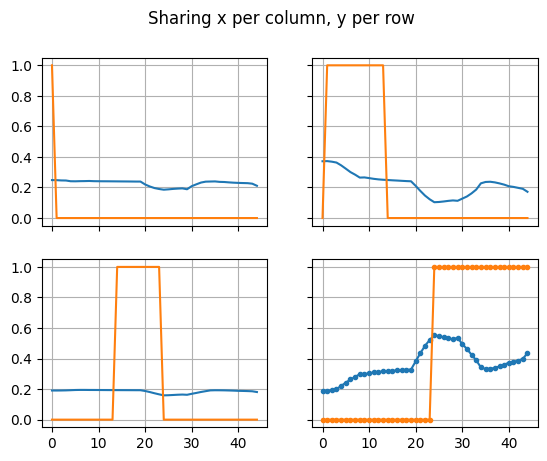

In [ ]:
#Ploting the output and input of the test set of multioutput LSTM
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Sharing x per column, y per row')
stress = D_Lstm.values[387:].T[5]# ZERO stress now LEVELS
ax1.plot(resultsG1[:,0])
ax1.plot(stress)
ax1.grid()

stress1 = D_Lstm.values[387:].T[2]# ONE stress now LEVELS
ax2.plot(resultsG1[:,1])
ax2.plot(stress1)
ax2.grid()

stress3 = D_Lstm.values[387:].T[3]# TWO stress now LEVELS
ax3.plot(resultsG1[:,2])
ax3.plot(stress3)
ax3.grid()

stress4 = D_Lstm.values[387:].T[4]# Three stress now LEVELS
ax4.plot(resultsG1[:,3],'.-')
ax4.plot(stress4,'.-')
ax4.grid()

for ax in fig.get_axes():
    ax.label_outer()
  

From previous pictures we can apreciated that ZERO level and barely stress3 have a good performance

**GROUP1 LSTM merge**

In [ ]:
df = merge[merge['Participant']==GROUP1[0]]
for a in range(1, len(GROUP1)):
  z = merge[merge['Participant']==GROUP1[a]]
  df = pd.concat([df,z], axis =0)
print(len(df))

432


In [ ]:
D_Lstm = df.copy()
#D_Lstm = D_Lstm.reset_index()
D_Lstm = D_Lstm.drop(['Participant','stress','Temp'], axis = 1)

n_tr, n_val = int(0.75*len(df)), int(0.125*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))
D_Lstm.head()

Samples for training: 324; validation: 54; test: 54


,Unnamed: 0,HR,EDA,Label
0,5.0,72.987667,0.191197,0.0
1,6.0,83.833000,0.222997,0.0
2,7.0,87.537000,0.247216,0.0
3,8.0,84.711667,0.262016,0.0
4,9.0,92.909333,0.265123,0.0


In [ ]:
# Get the data from the dataframe (dropping date column)
data = D_Lstm.iloc[:, 1:-1].values
print(data.shape)
# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
#data[:n_tr, :-1]
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data[:, :] = (data[:, :] - mean_tr) / std_tr

y = D_Lstm['Label'].values.reshape(-1, 1)

(432, 2)


In [ ]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 5  # 2.5 min to predict stress or not
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 54 

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val 
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    break  # so we only print once

X shape: (54, 5, 2)
target shape: (54, 1)


In [ ]:
#Defing the model
model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(40, input_shape=(sequence_length, len(D_Lstm.columns)-2)))
model_lstm2.add(layers.Dense(1))
model_lstm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40)                6880      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6,921
Trainable params: 6,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 40

In [ ]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/40
6/6 [==============================] - 2s 93ms/step - loss: 0.9729 - mae: 0.8570 - val_loss: 1.1140 - val_mae: 0.9528
Epoch 2/40
6/6 [==============================] - 0s 20ms/step - loss: 0.9445 - mae: 0.8450 - val_loss: 1.1197 - val_mae: 0.9566
Epoch 3/40
6/6 [==============================] - 0s 25ms/step - loss: 0.9374 - mae: 0.8420 - val_loss: 1.1231 - val_mae: 0.9590
Epoch 4/40
6/6 [==============================] - 0s 22ms/step - loss: 0.9325 - mae: 0.8401 - val_loss: 1.1269 - val_mae: 0.9614
Epoch 5/40
6/6 [==============================] - 0s 20ms/step - loss: 0.9287 - mae: 0.8384 - val_loss: 1.1311 - val_mae: 0.9638
Epoch 6/40
6/6 [==============================] - 0s 21ms/step - loss: 0.9255 - mae: 0.8369 - val_loss: 1.1356 - val_mae: 0.9664
Epoch 7/40
6/6 [==============================] - 0s 23ms/step - loss: 0.9226 - mae: 0.8355 - val_loss: 1.1401 - val_mae: 0.9688
Epoch 8/40
6/6 [==============================] - 0s 20ms/step - loss: 0.9200 - mae: 0.8341 - val

In [ ]:
print('Test MAE = %.2f stress' % model_lstm2.evaluate(test_dataset)[1])
resultsG2 = model_lstm2.predict(test_dataset)
print('Validation MAE = %.2f stress' % model_lstm2.evaluate(val_dataset)[1])
resultsV2 = model_lstm2.predict(val_dataset)
len(resultsG2)

1/1 [==============================] - 0s 63ms/step - loss: 0.8130 - mae: 0.8035
Test MAE = 0.80 stress
1/1 [==============================] - 0s 66ms/step - loss: 1.2137 - mae: 1.0013
Validation MAE = 1.00 stress
1/1 [==============================] - 0s 56ms/step


45

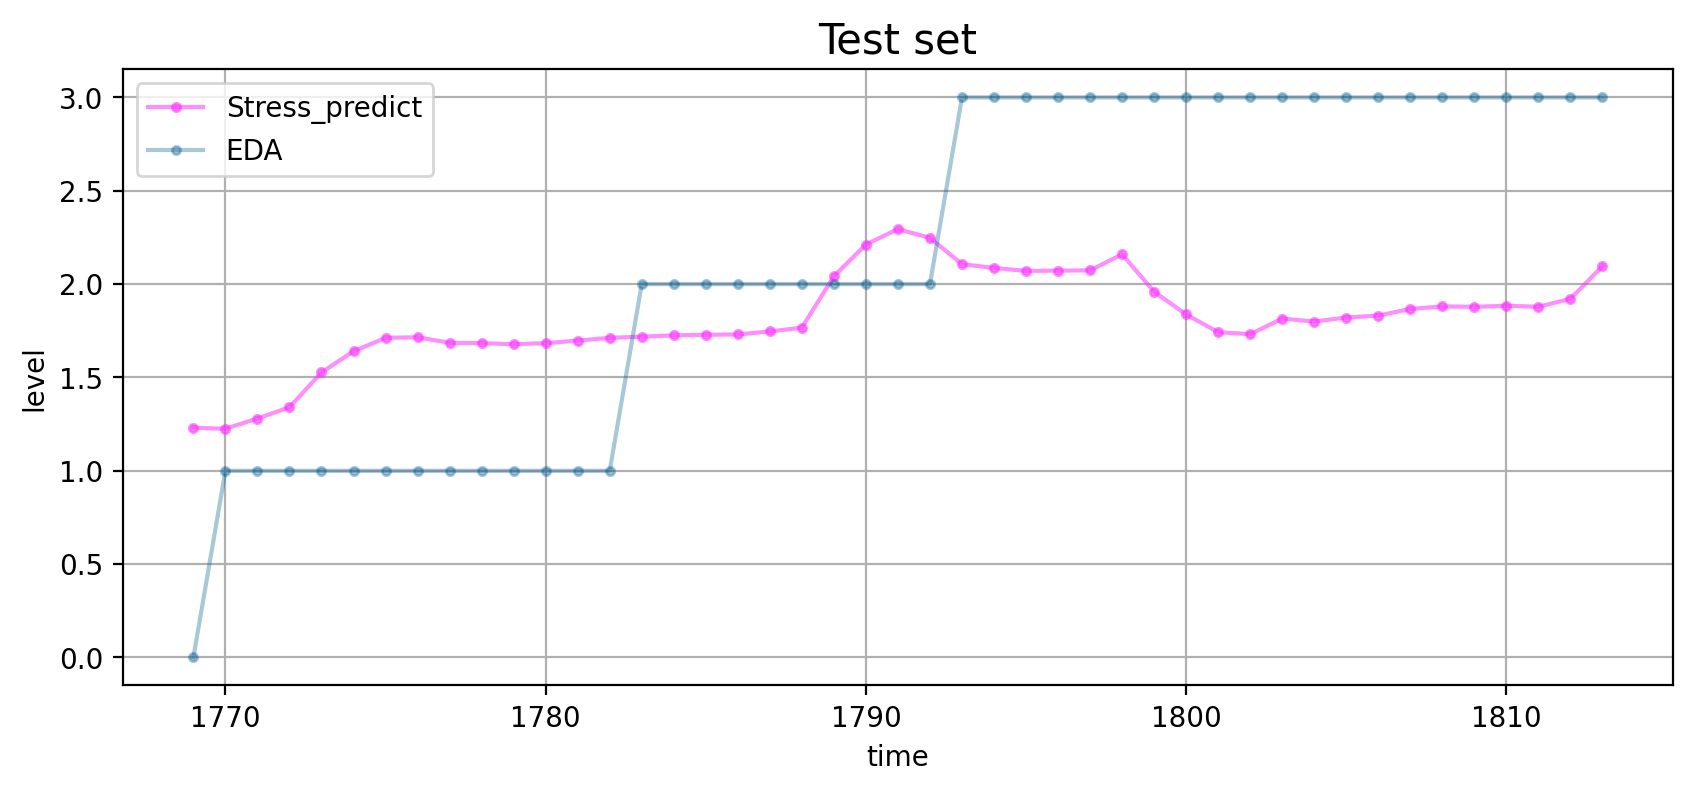

In [ ]:
x=D_Lstm.index[387:]
t=x.to_numpy()
#stress = D_Lstm.values[387:].T[5]# stress now LEVELS
stressVAL = D_Lstm.values[387:].T[3]
plt.figure(figsize=(10,4), dpi=200)
#plt.plot(t, stress,'.-',color="#A233FF",alpha=0.35,label="Stress")
plt.plot(t, resultsG2,'.-',color="#FD33FF",alpha=0.55,label="Stress_predict")
plt.plot(t, stressVAL,'.-',color="#086092",alpha=0.35,label="EDA")
plt.title("Test set",fontsize=15)
plt.legend()
plt.xlabel("time")
plt.ylabel("level")
plt.grid('True')
plt.show()

In [ ]:
#It tries to follow the pattern but the oputput is an integer and if predict output is carried to integeter we could get the error.

In [ ]:
D_Lstm=D_Lstm.reset_index() # to plot train set 

In [ ]:
resultsT2 = model_lstm2.predict(train_dataset)
len(resultsT2)

6/6 [==============================] - 0s 9ms/step


320

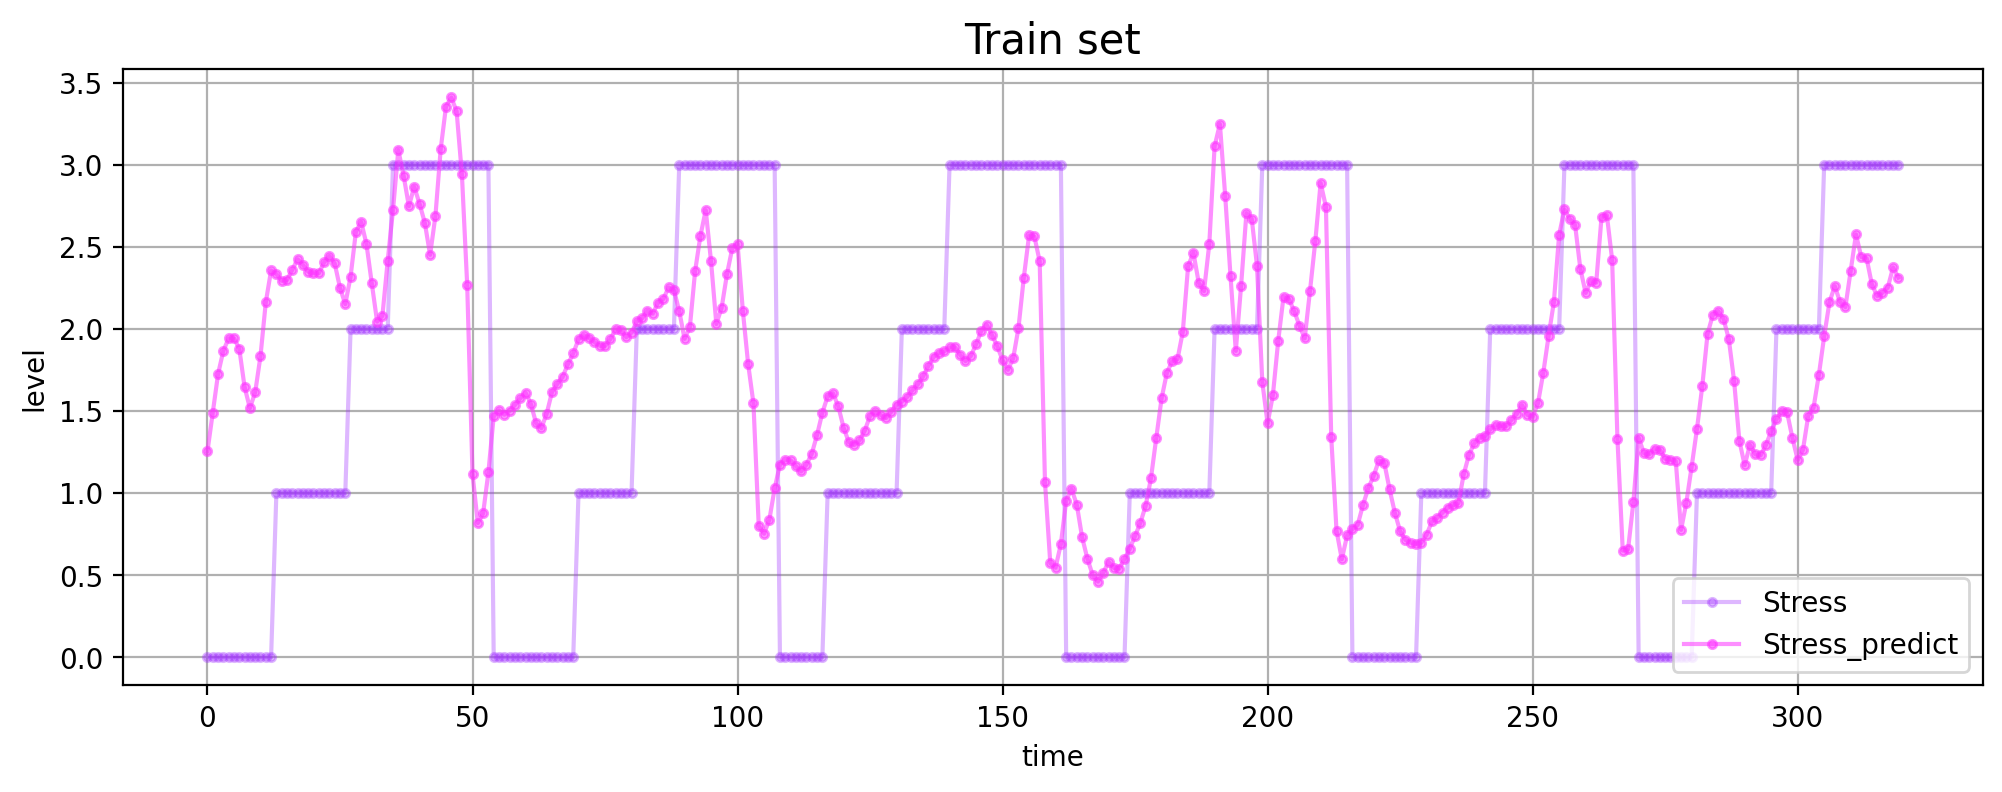

In [ ]:
#As the performance is poor we want to see the result of model with the train set
x=D_Lstm.index[0:320]
t=x.to_numpy()
stress = D_Lstm.values[0:320].T[4]# stress now LEVELS
#stressEDA = D_Lstm.values[0:320].T[]
plt.figure(figsize=(12,4), dpi=200)
plt.plot(t, stress,'.-',color="#A233FF",alpha=0.35,label="Stress")
plt.plot(t, resultsT2,'.-',color="#FD33FF",alpha=0.55,label="Stress_predict")
#plt.plot(t, stressEDA,'.-',color="#086092",alpha=0.35,label="EDA")
plt.title("Train set",fontsize=15)
plt.legend()
plt.xlabel("time")
plt.ylabel("level")
plt.grid('True')
plt.show()

In [ ]:
#Transforming predicted output to integers
print(resultsG2.shape)
aux = []
for h in range(0,len(resultsG2)):
  aux.append(round(resultsG2[h,0]))

(45, 1)


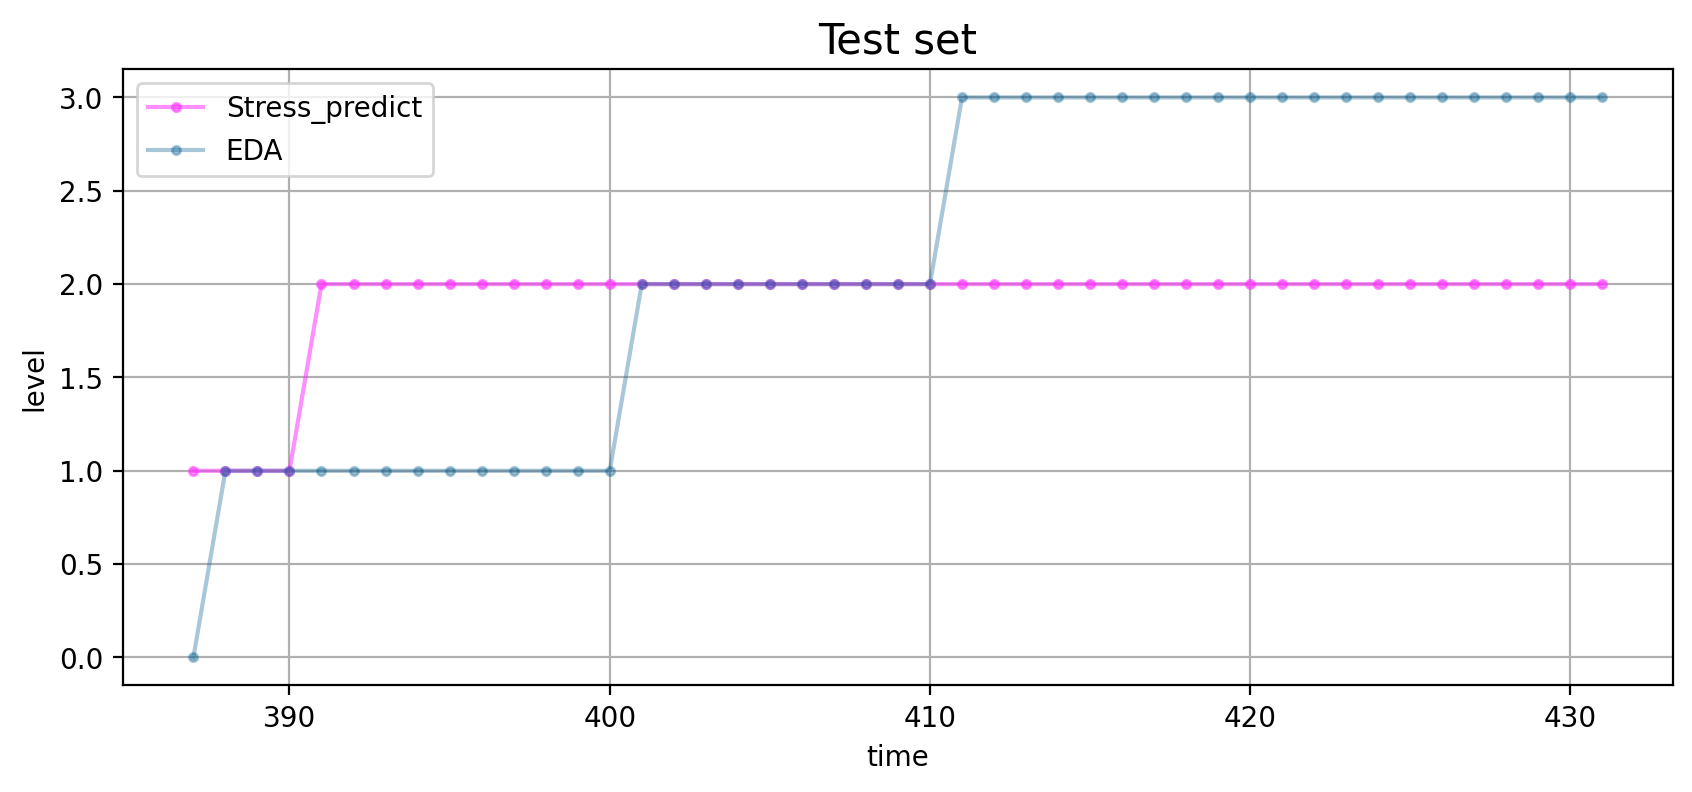

In [ ]:
#Now we plot output and predicted round output
x=D_Lstm.index[387:]
t=x.to_numpy()
#As index was added
stressVAL = D_Lstm.values[387:].T[4]
plt.figure(figsize=(10,4), dpi=200)
#plt.plot(t, stress,'.-',color="#A233FF",alpha=0.35,label="Stress")
plt.plot(t, aux,'.-',color="#FD33FF",alpha=0.55,label="Stress_predict")
plt.plot(t, stressVAL,'.-',color="#086092",alpha=0.35,label="EDA")
plt.title("Test set",fontsize=15)
plt.legend()
plt.xlabel("time")
plt.ylabel("level")
plt.grid('True')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(stressVAL, aux)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.75       0.24390244 0.        ]
recall: [0.         0.23076923 1.         0.        ]
fscore: [0.         0.35294118 0.39215686 0.        ]
support: [ 1 13 10 21]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print("Accuracy:",metrics.accuracy_score(stressVAL, aux))

Accuracy: 0.28888888888888886
